In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
traffic_data = pd.read_csv('/content/drive/MyDrive/traffic predict/traffic_flow_data/flows/GD030A_S.csv')

In [5]:
# Step 2: reconstruct the data
traffic_data['date'] = pd.to_datetime(traffic_data['date'])
traffic_data['datetime'] = traffic_data['date'] + pd.to_timedelta(traffic_data['time'], unit='h')
traffic_data.set_index('datetime', inplace=True)
traffic_data.drop(columns=['date', 'time'], inplace=True)

In [5]:
# Step 3: Create multiple lag features
# Create lag features for the last 12 hours
for i in range(1, 13):
    traffic_data[f'lag{i}'] = traffic_data['flow'].shift(i)

# Add lag features for 24 hours (1 day) ago and 168 hours (1 week) ago
traffic_data['lag24'] = traffic_data['flow'].shift(24)       # 24 hours ago (1 day ago)
traffic_data['lag168'] = traffic_data['flow'].shift(168)     # 168 hours ago (1 week ago)

traffic_data.dropna(inplace=True)

In [6]:
# Step 4: Create features (X) and target (y)
X = traffic_data[[f'lag{i}' for i in range(1, 13)] + ['lag24', 'lag168']].values
y = traffic_data['flow'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Standardize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

In [7]:
# Step 5: train the model
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
}

# Initialize the SVR model
svr = SVR(kernel='rbf')

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train_scaled)

# Extract the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END ...................C=0.1, epsilon=0.01, gamma=scale; total time=  23.7s
[CV] END ...................C=0.1, epsilon=0.01, gamma=scale; total time=  23.1s
[CV] END ...................C=0.1, epsilon=0.01, gamma=scale; total time=  23.2s
[CV] END ...................C=0.1, epsilon=0.01, gamma=scale; total time=  23.1s
[CV] END ...................C=0.1, epsilon=0.01, gamma=scale; total time=  23.0s
[CV] END ....................C=0.1, epsilon=0.01, gamma=auto; total time=  22.9s
[CV] END ....................C=0.1, epsilon=0.01, gamma=auto; total time=  23.0s
[CV] END ....................C=0.1, epsilon=0.01, gamma=auto; total time=  22.9s
[CV] END ....................C=0.1, epsilon=0.01, gamma=auto; total time=  22.9s
[CV] END ....................C=0.1, epsilon=0.01, gamma=auto; total time=  23.1s
[CV] END ...................C=0.1, epsilon=0.01, gamma=0.001; total time=  23.2s
[CV] END ...................C=0.1, epsilon=0.01

In [41]:
# Number of steps to predict ahead for each rolling window
n_steps_ahead = 6

# Prepare to store all predictions and the corresponding actual values
all_predictions = []
all_actuals = []

# Retrieve means and standard deviations for manual scaling
mean_lag1 = scaler_X.mean_[0]  # mean of lag1
std_lag1 = scaler_X.scale_[0]  # std of lag1

mean_lag24 = scaler_X.mean_[12]  # mean of lag24
std_lag24 = scaler_X.scale_[12]  # std of lag24

mean_lag168 = scaler_X.mean_[13]  # mean of lag168
std_lag168 = scaler_X.scale_[13]  # std of lag168

# Perform the rolling forecast
for start in range(len(X_test_scaled) - n_steps_ahead + 1):
    # Initialize the feature set with the current starting point in the test set
    current_features = X_test_scaled[start].reshape(1, -1)

    # Store the predictions for this rolling window
    y_multi_step_pred = []

    for i in range(n_steps_ahead):
        # Predict the next step using the standardized features
        next_step_scaled = best_model.predict(current_features)

        # Inverse transform the prediction to get the actual value
        next_step = scaler_y.inverse_transform(next_step_scaled.reshape(-1, 1)).ravel()[0]

        # Store the prediction
        y_multi_step_pred.append(next_step)

        # Update the feature set for the next prediction
        new_features = current_features.flatten()
        new_features[1:13] = new_features[0:12]  # Shift lag1 to lag12
        new_features[0] = next_step_scaled  # Use the scaled prediction for lag1

        # Manually scale the values for lag24 and lag168 using their respective means and stds
        if start + i + 24 < len(y_test):
            new_features[12] = (y_test[start + i] - mean_lag24) / std_lag24  # Scale manually
        else:
            new_features[12] = new_features[i - 24] if i >= 24 else 0

        if start + i + 168 < len(y_test):
            new_features[13] = (y_test[start + i] - mean_lag168) / std_lag168  # Scale manually
        else:
            new_features[13] = new_features[i - 168] if i >= 168 else 0

        # Reshape the updated features back to 2D for the next iteration
        current_features = new_features.reshape(1, -1)

    # Append predictions and actuals to the overall lists
    all_predictions.append(y_multi_step_pred)
    all_actuals.append(y_test[start:start + n_steps_ahead])

# Convert the lists to arrays for easier processing
all_predictions = np.array(all_predictions)
all_actuals = np.array(all_actuals)


Streaming output truncated to the last 5000 lines.
<ipython-input-41-6edb8f65ad97>:39: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-41-6edb8f65ad97>:39: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-41-6edb8f65ad97>:39: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-41-6edb8f65ad97>:39: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a sing

In [42]:
# Initialize lists to store the metrics for each step
rmse_per_step = []
mae_per_step = []
mape_per_step = []

# Evaluate metrics for each step separately
for step in range(n_steps_ahead):
    y_pred_step = all_predictions[:, step]
    y_actual_step = all_actuals[:, step]

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_actual_step, y_pred_step))
    rmse_per_step.append(rmse)

    # Calculate MAE
    mae = mean_absolute_error(y_actual_step, y_pred_step)
    mae_per_step.append(mae)

    # Calculate MAPE
    mape = np.mean(np.abs((y_actual_step - y_pred_step) / y_actual_step)) * 100
    mape_per_step.append(mape)

# Convert lists to pandas Series for better display
rmse_per_step = pd.Series(rmse_per_step, index=np.arange(1, n_steps_ahead + 1), name='RMSE')
mae_per_step = pd.Series(mae_per_step, index=np.arange(1, n_steps_ahead + 1), name='MAE')
mape_per_step = pd.Series(mape_per_step, index=np.arange(1, n_steps_ahead + 1), name='MAPE')

# Display the results
print("RMSE:")
print(rmse_per_step)
print("\nMAE:")
print(mae_per_step)
print("\nMAPE:")
print(mape_per_step)

RMSE:
1    33.376989
2    36.918133
3    39.437535
4    41.392114
5    44.099982
6    48.237638
Name: RMSE, dtype: float64

MAE:
1    22.582612
2    25.556080
3    27.447271
4    28.542932
5    29.477226
6    30.158371
Name: MAE, dtype: float64

MAPE:
1    27.004298
2    28.793077
3    31.105585
4    33.076645
5    34.916695
6    36.447851
Name: MAPE, dtype: float64


In [32]:
# Step 6: Use the best model to predict on the test set
y_pred_scaled = best_model.predict(X_test_scaled)

# Reshape the 1D array to a 2D array before inverse transformation
y_pred_scaled = y_pred_scaled.reshape(-1, 1)

# Perform the inverse transformation
y_pred = scaler_y.inverse_transform(y_pred_scaled)

y_pred = y_pred.ravel()

# Evaluate the best model
mse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Output the results
print(f"Best Parameters: {best_params}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}%")
print(f"Predictions: {y_pred[:10]}")
print(f"Actual values: {y_test[:10]}")


Best Parameters: {'C': 100, 'epsilon': 0.1, 'gamma': 0.01}
Mean Squared Error: 33.365302021859016
Mean Absolute Error: 22.570384732478264
Mean Absolute Percentage Error: 26.98860814544653%
Predictions: [209.68129114 207.32827509 190.32489621 133.58357069 138.49522858
 113.53721786  87.60455033  67.09712053  40.72572961  27.32408673]
Actual values: [225 191 197 178 128 140 104  54  35  33]


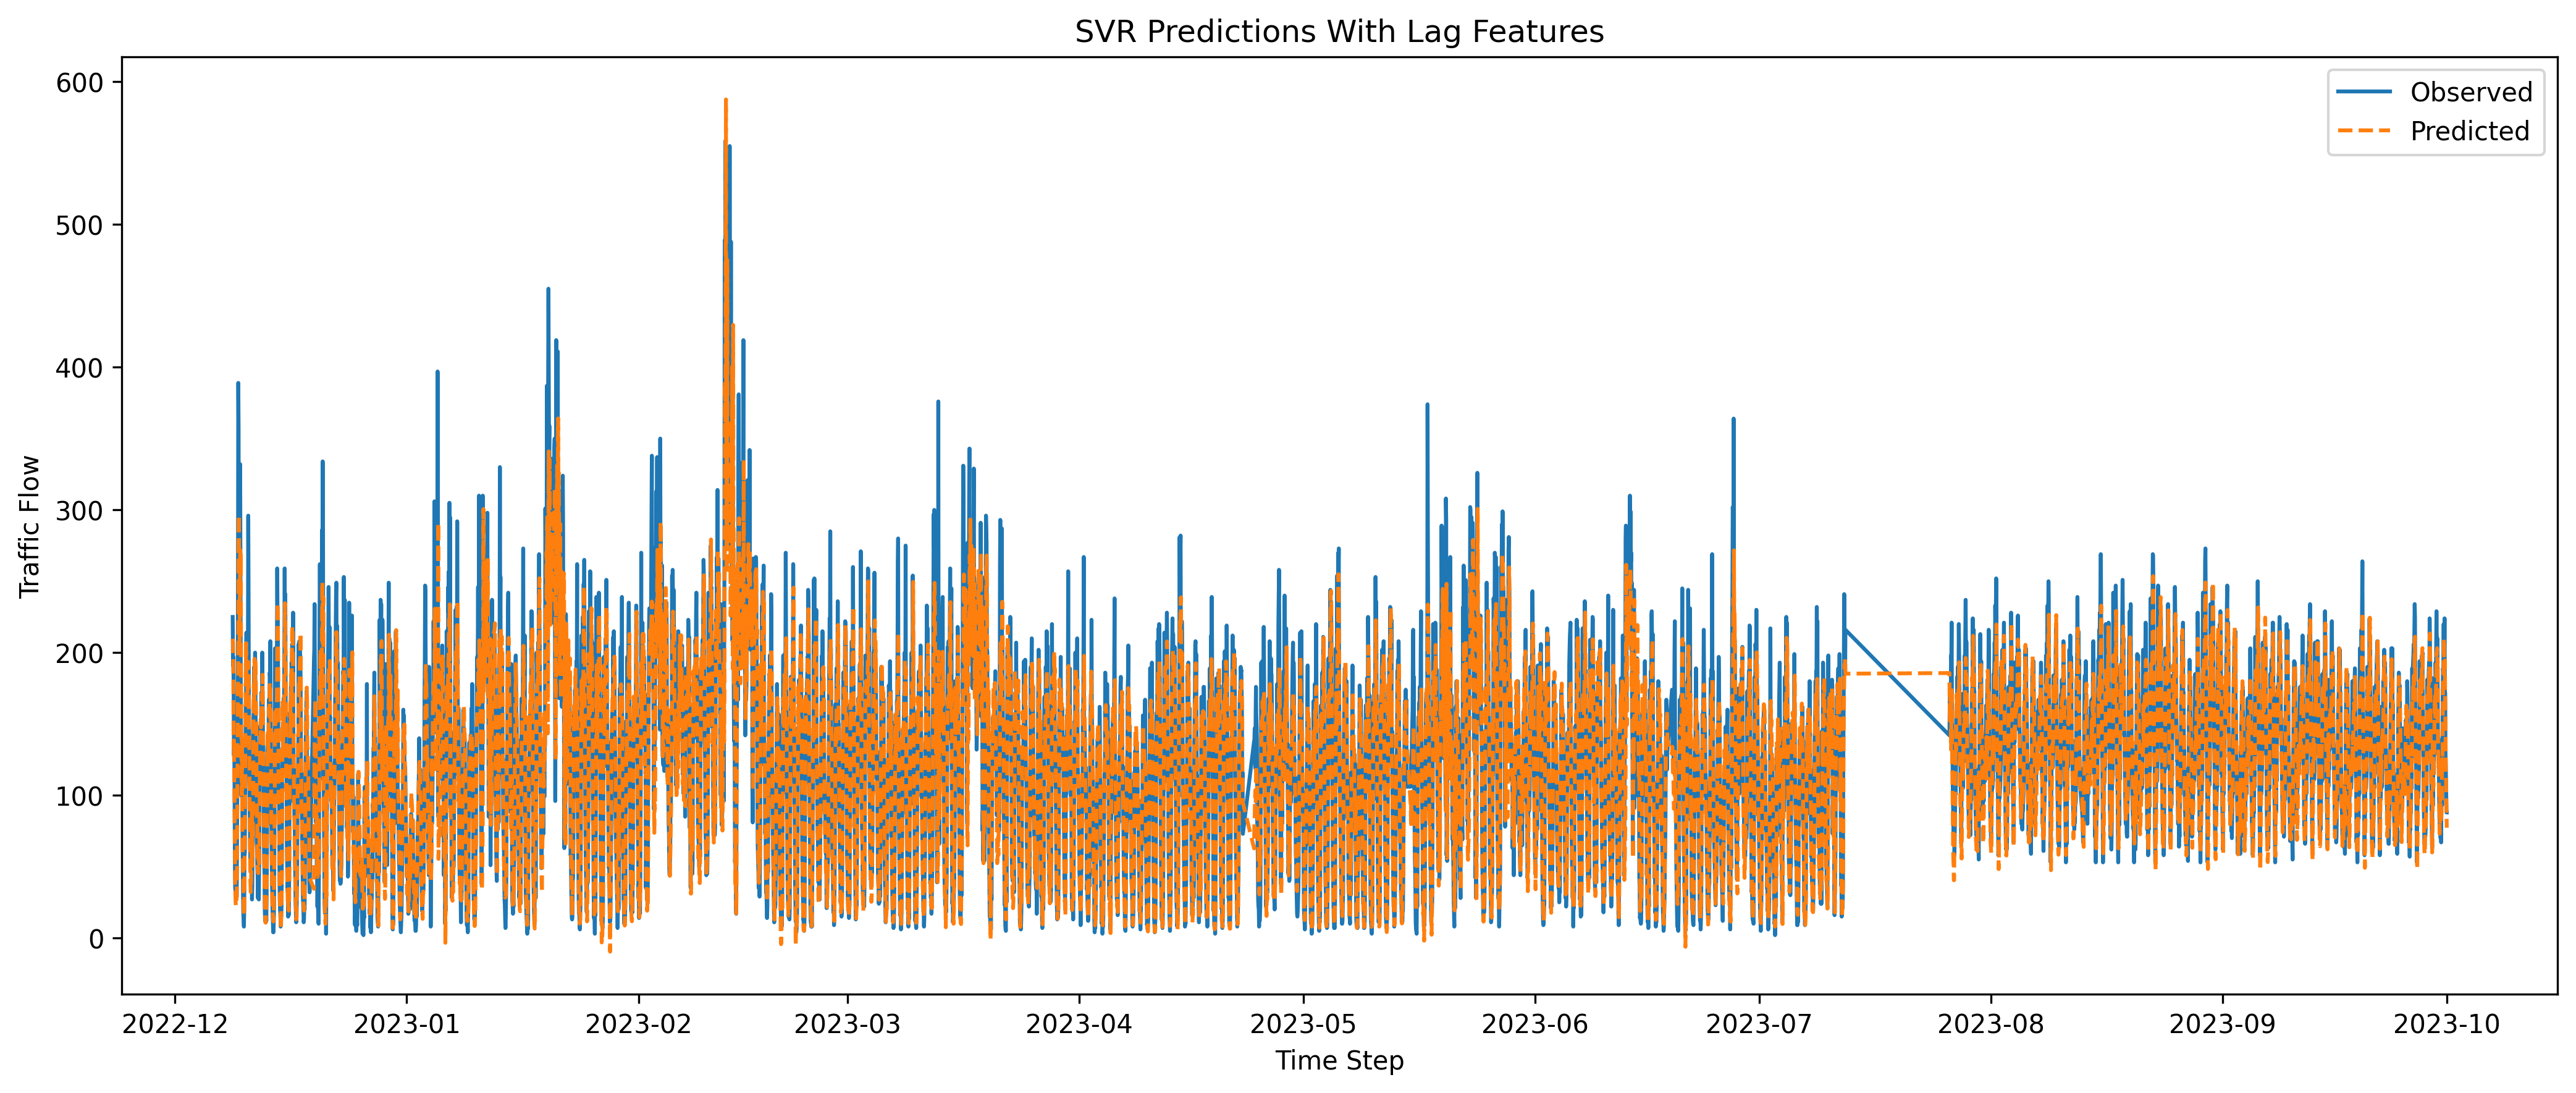

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6), dpi=300)

timestamps = traffic_data.index[-len(y_test):]

plt.plot(timestamps,y_test, label='Observed')
plt.plot(timestamps,y_pred, label='Predicted', linestyle='--')
plt.title('SVR Predictions With Lag Features')
plt.xlabel('Time Step')
plt.ylabel('Traffic Flow')
plt.legend()

plt.tight_layout()
plt.show()


In [23]:
import plotly.graph_objects as go
# Create interactive plot using Plotly
fig = go.Figure()

# Add observed data to the plot
fig.add_trace(go.Scatter(x=timestamps, y=y_test, mode='lines', name='Observed Data'))

# Add 1-step-ahead forecasts to the plot
fig.add_trace(go.Scatter(x=timestamps, y=y_pred, mode='lines', name='Forecast', line=dict(dash='dash')))

# Update layout for better visualization
fig.update_layout(
    title='Observed Data and Forecasts using SVR',
    xaxis_title='Date',
    yaxis_title='Traffic Flow',
    legend_title='Legend'
)

# Show the plot
fig.show()

In [1]:
print(f"Best Parameters: {best_params}")

NameError: name 'best_params' is not defined

In [7]:
# Assuming traffic_data['flow'] is the target and traffic_data has a datetime index
X = traffic_data.index.astype(np.int64).values.reshape(-1, 1)  # Use the datetime index as a feature
y = traffic_data['flow'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Standardize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# Perform cross-validation to evaluate the model
svr = SVR(kernel='rbf')

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train_scaled)

# Best model after CV
best_model = grid_search.best_estimator_

# Print the best parameters found during CV
print(f"Best Parameters: {grid_search.best_params_}")

# Train the SVR model with the best parameters on the full training data
best_model.fit(X_train_scaled, y_train_scaled)

# Predict on the test data
y_pred_scaled = best_model.predict(X_test_scaled)

# Inverse transform the predictions to get the original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Evaluate the results
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test Set Mean Absolute Error (MAE): {mae}")
print(f"Test Set Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"Test Set Root Mean Squared Error (RMSE): {rmse}")

Best Parameters: {'C': 0.1, 'epsilon': 0.01, 'gamma': 0.1}
Test Set Mean Absolute Error (MAE): 58.539120709783155
Test Set Mean Absolute Percentage Error (MAPE): 146.94104401150918%
Test Set Root Mean Squared Error (RMSE): 72.84393153535065


In [8]:
y_pred

array([117.00489681, 117.00848914, 117.012082  , ..., 151.70993676,
       151.71534585, 151.72075489])

In [10]:
traffic_data.describe()

,flow
count,33643.000000
mean,124.620515
std,80.609885
min,0.000000
25%,58.000000
50%,124.000000
75%,175.000000
max,559.000000
